# AIAP11 EDA

### Loading required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.extract import ImportData
from src.config.config_load import read_yaml_file

### Loading dataset

In [2]:
# Reading in data location from config file
config = read_yaml_file()
data_location = config["data"]["data_location"]
data_table = config["data"]["data_table"]

# Calling the data from module 1
table = ImportData(data_location).return_table(data_table)
table

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0.0


### Basic Data Description

Wanted to look at:
1. Types of categories within the dataset and if they were classified correctly 
2. Column names and information if it tallies with information provided by AISG 
3. Any other salient information that might suggest how data was captured and how it was put together

In [3]:
num_cat = table.select_dtypes(include=[np.number])
cat_cat = table.select_dtypes(include="object")
for each in cat_cat:
    table[each] = table[each].astype("category")

print(f"There are {table.shape[1]} columns in the dataset with {table.shape[0]} observations")
print(f"There are {num_cat.shape[1]} numerical columns and {cat_cat.shape[1]} categorical columns in the dataset")
print(f"There are {table.isna().sum().sum()} empty observations in dataset")

table.isna().sum()

There are 15 columns in the dataset with 119391 observations
There are 5 numerical columns and 10 categorical columns in the dataset
There are 46507 empty observations in dataset


booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64

In [4]:
table.columns

Index(['booking_id', 'no_show', 'branch', 'booking_month', 'arrival_month',
       'arrival_day', 'checkout_month', 'checkout_day', 'country',
       'first_time', 'room', 'price', 'platform', 'num_adults',
       'num_children'],
      dtype='object')

In [5]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   booking_id      119391 non-null  int64   
 1   no_show         119390 non-null  float64 
 2   branch          119390 non-null  category
 3   booking_month   119390 non-null  category
 4   arrival_month   119390 non-null  category
 5   arrival_day     119390 non-null  float64 
 6   checkout_month  119390 non-null  category
 7   checkout_day    119390 non-null  float64 
 8   country         119390 non-null  category
 9   first_time      119390 non-null  category
 10  room            97778 non-null   category
 11  price           94509 non-null   category
 12  platform        119390 non-null  category
 13  num_adults      119390 non-null  category
 14  num_children    119390 non-null  float64 
dtypes: category(10), float64(4), int64(1)
memory usage: 8.5 MB


### Data Cleaning and Preprocessing
Data cleaning steps taken:
1. Remove one row that was completly empty within the dataset row number: 115536 (data-entry error or import parsing error)
2. Separate price into currency and value to allow for better comparison (data-entry error or database parsing error)
3. "num_adults" was a freetext field, hence changed [1,2,"one", "two"] within series into [1,2] (data-entry error)
4. Several columns was saved as float in database but should have been integers 
5. "first_time" should be converted to boolean [True, False]
6. "no_show" should be converted to boolean [True, False]
7. There are some checkout days which are negative in value, processed to return positive (date-entry error)
8. There seems to be different naming conventions for arrival_months

In [6]:
# 1. Remove one row that was completely empty within the dataset row number: 115536
# table shape before
print(f"table shape before processing {table.shape}")

# Set booking_id as index
table = table.set_index("booking_id")

# Removing empty data line table.iloc[table.index[115536], :]
table.dropna(how="all", axis=0, inplace=True)

# Checking table shape after removal
print(f"table shape after processing {table.shape}")

table shape before processing (119391, 15)
table shape after processing (119390, 14)


In [7]:
# 2. Separate price into currency and value to allow for better comparison
# Identify the observations which have "None" and replace with np.nan
table = table.replace(["None", "nan"], np.nan)

# Split out currency from room price
table["currency"] = table.price.apply(lambda x: np.nan if x is None else x[:3]).astype("category")

# Split out price from price
def split_price(price):
    """Parse out the relevant price from the series
    Args:
        price (string): price with full currency and price 
    Returns:
        price: float point price
    """
    if price == "None" or price is None:
        return np.nan
    else:
        return float(price[5:])

table["price"] = table.price.apply(lambda x: split_price(x))

# Convert to a single currency base, SGD, historical average currency exchange of 1.3439 was used
table["SGD_price"] = np.where(table["currency"] == "USD", round(table["price"]*1.3439,2) , table["price"])

In [8]:
# 3. "num_adults" was a freetext field, hence changed [1,2,"one", "two"] within series into [1,2]
# changing number of adults to integers
def chg_to_num(num):
    """Change numbers from string to integers for use in lambda only
    Args:
        num (string): string version of integer
    Returns:
        num: numerical version of string integer
    """
    num_dict = {"one":1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9, 'ten':10}
    if num is None:
        return np.nan
    elif num in num_dict.keys():
        return int(num_dict[num])
    else:
        return int(num)

table["num_adults"] = table.num_adults.apply(lambda x: chg_to_num(x))

In [9]:
# 4. Several columns was saved as float in database but should have been integers  ["num_adults", "arrival_day", "checkout_day", "num_children"]
# columns that needs to be changed to integers
int_cols = ["num_adults", "arrival_day", "checkout_day", "num_children"]

# Changed all other data from float to categorical
table[int_cols] = table[int_cols].astype("int")

In [10]:
# 5. "first_time" should be converted to boolean [1,0]
def to_bool(non_bool):
    if non_bool in ("Yes", 1):
        return True
    return False

# change first_time to either True for "Yes" or False for "No"
table["first_time"] = table["first_time"].apply(lambda x: to_bool(x))

# 6. "no_show" should be converted to boolean [1,0]
# change first_time to either True for "Yes" or False for "No"
table["no_show"] = table["no_show"].apply(lambda x: to_bool(x))

In [11]:
# 7. There are some checkout days which are negative in value
def checkout_neg(num):
    """For each day provided return the absolute number
    Args:
        num (integer): checkout day provided
    Returns:
        num: absolute value of number given
    """
    if num<0:
        return abs(num)
    else:
        return num

table["checkout_day"] = table.checkout_day.apply(lambda x: checkout_neg(x))

In [12]:
# 8. There seems to be different cases for the same months ['September', 'SepTember', 'SeptemBer']
def title_case(month):
    """Change input into titlecase 
    Args:
        month (string): month input
    Returns:
        month: month in title case
    """
    if isinstance(month, str):
        return month.title()

table["arrival_month"] = table["arrival_month"].apply(lambda x: title_case(x)).astype("category")

In [13]:
df = table.copy()
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 94113 to 99643
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   no_show         119390 non-null  bool    
 1   branch          119390 non-null  category
 2   booking_month   119390 non-null  category
 3   arrival_month   119390 non-null  category
 4   arrival_day     119390 non-null  int32   
 5   checkout_month  119390 non-null  category
 6   checkout_day    119390 non-null  int64   
 7   country         119390 non-null  category
 8   first_time      119390 non-null  category
 9   room            97778 non-null   category
 10  price           94509 non-null   float64 
 11  platform        119390 non-null  category
 12  num_adults      119390 non-null  int32   
 13  num_children    119390 non-null  int32   
 14  currency        94509 non-null   category
 15  SGD_price       94509 non-null   float64 
dtypes: bool(1), category(9), float64(2)

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,currency,SGD_price
booking_id,,,,,,,,,,,,,,,,
94113,False,Changi,November,June,25,June,27,Singapore,True,Single,492.98,Website,1,0,SGD,492.98
86543,False,Orchard,August,November,28,November,29,Indonesia,True,King,1351.22,Website,2,0,SGD,1351.22
75928,False,Changi,March,February,7,February,11,India,True,Single,NaN,Agent,1,0,NaN,NaN
66947,True,Orchard,September,October,1,October,3,China,True,Single,666.04,Website,1,0,SGD,666.04
106390,False,Orchard,March,June,20,June,24,Australia,True,Queen,665.37,Website,1,0,USD,894.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,False,Changi,September,April,3,April,5,China,True,King,612.18,Website,1,1,USD,822.71
25062,False,Orchard,March,December,30,January,3,China,True,King,1041.29,Email,2,0,USD,1399.39
81936,True,Changi,September,March,31,April,1,Indonesia,True,King,641.47,Email,1,2,USD,862.07


### Exploratory Data Analysis

#### Relook Objectives of application
- **"Predict the No-Show** of customers to help a hotel chain to formulate policies to **reduce expenses incurred** due to No-Shows"

---
#### EDA Thought process
1. Classification model limitations 
    1. [ ] Is data set imbalanced?

2. What features should we be looking out for and what feature engineering needs to be done? 
    1. [x] Are those with children more or less likely to no-show?
    2. [x] Are there specific countries that are more likely to no-show?
    3. [ ] Which months are no-shows more likely?
        - a. [ ] arrival month 
        - b. [ ] checkout month 
    4. [x] Is there a difference in no-show between booking platforms?
    5. [x] Is there a difference in no-show between the different hotel branches
    6. [x] Are first time customers more likely to no-show?
    7. [x] Is low room price a reason for no-show?
    8. [ ] Is room type a factor for no-show?


##### 1. Classification Model Limitations

   no_show  branch  percentage
0    False   75166       62.96
1     True   44224       37.04


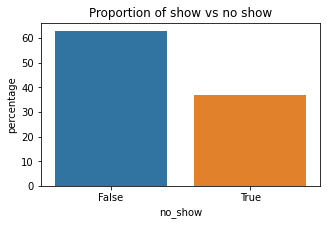

Not heavily imbalanced dataset. Overall percentage of no_show is also consistent with industry metrics (e.g. Expedia & Bookings.com)


In [33]:
# 1. Check id dataset is imbalanced
imb = df.groupby("no_show")["branch"].count().reset_index()
imb["percentage"] = round((imb.branch / imb.branch.sum()) *100,2)
print(imb)

# Plot
plt.figure(figsize = (5,3))
sns.barplot(data=imb, x="no_show", y="percentage").set(title="Proportion of show vs no show")
plt.show()

# Findings
print("Not heavily imbalanced dataset. Overall percentage of no_show is also consistent with industry metrics (e.g. Expedia & Bookings.com)")

##### 2. Feature Engineering EDA

In [15]:
# 1. Are those with children more or less likely to no-show?
df["with_child"] = df.num_children.apply(lambda x: True if x>0 else False)
child = df.groupby("with_child")["no_show"].sum().reset_index()
child["percentage"] = round((child.no_show / child.no_show.sum()) *100,2)
print(child)

# Findings
print(f"Those with children have a {child.iloc[1,-1]}% chance of no show vs those without children {child.iloc[0,-1]}%")


   with_child  no_show  percentage
0       False    16264       36.78
1        True    27960       63.22
Those with children have a 63.22% chance of no show vs those without children 36.78%


     country    sum  count  pct_no_show  prop_no_show
0      China  27519  48590        56.64         62.23
1   Malaysia   1333   3766        35.40          3.01
2  Indonesia   6894  25812        26.71         15.59
3  Singapore    939   3912        24.00          2.12
4      India   3481  15790        22.05          7.87
5  Australia   2453  12129        20.22          5.55
6      Japan   1605   9391        17.09          3.63


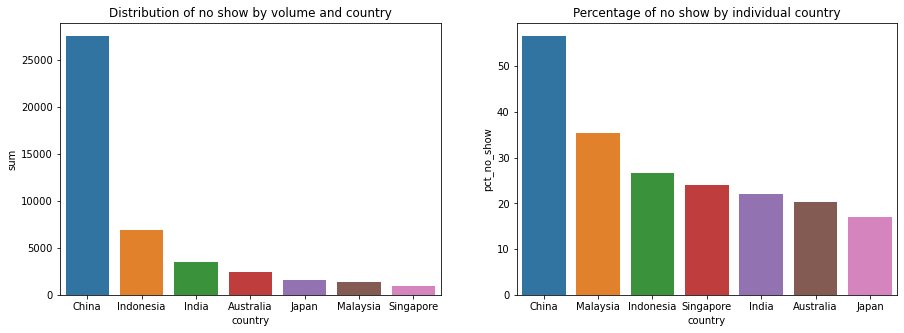


In terms of overall volume customers from China and Indonesia form the largest bulk of no show customers. 
However, there also seems to be a high proportion of customers from China and Malaysia who dont turn up



In [51]:
# 2. Are there specific countries that are more likely to no-show?
country = df.groupby("country")["no_show"].agg(["sum", "count"]).reset_index()
country["pct_no_show"] = round((country["sum"]/country["count"])*100,2)
country["prop_no_show"] = round((country["sum"]/country["sum"].sum())*100,2)
country = country.sort_values("pct_no_show", ascending=False).reset_index(drop=True)
print(country)

# Plotting
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
sns.barplot(data=country, x="country", y="sum", order=country.sort_values("sum", ascending=False).country).set(title="Distribution of no show by Volume and Country")
plt.subplot(1, 2, 2)
sns.barplot(data=country, x="country", y="pct_no_show", order=country.sort_values("pct_no_show", ascending=False).country).set(title="Percentage of no show by Individual Country")
plt.show()

# Findings
print(f"""
In terms of overall volume customers from {country.iloc[0, 0]} and {country.iloc[2, 0]} form the largest bulk of no show customers. 
However, there also seems to be a high proportion of customers from {country.iloc[0, 0]} and {country.iloc[1, 0]} who dont turn up
""")

In [17]:
# 3.a Which months are no-shows more likely?
months_arr = df.groupby("arrival_month")["no_show"].agg(["sum", "count"]).reset_index()
months_arr["pct_no_show"] = round((months_arr["sum"]/months_arr["count"])*100,2)
print(months_arr.sort_values("pct_no_show", ascending=False))

# Findings
print(f"The mean {round(months_arr.pct_no_show.mean(),2)}% is close to overall dataset {imb.iloc[1,2]}%")
print(f"There is no obvious trend between arrival month and no shows")

   arrival_month   sum  count  pct_no_show
6           June  4535  10939        41.46
0          April  4524  11089        40.80
8            May  4677  11791        39.67
11     September  4116  10508        39.17
10       October  4246  11160        38.05
1         August  5239  13877        37.75
5           July  4742  12661        37.45
2       December  2371   6780        34.97
3       February  2696   8068        33.42
7          March  3149   9794        32.15
9       November  2122   6794        31.23
4        January  1807   5929        30.48
The mean 36.38% is close to overall dataset 37.04%
There is no obvious trend between arrival month and no shows


In [18]:
# 3.a Which months are no-shows more likely?
months_checkout = df.groupby("checkout_month")["no_show"].agg(["sum", "count"]).reset_index()
months_checkout["pct_no_show"] = round((months_checkout["sum"]/months_checkout["count"])*100,2)
print(months_checkout.sort_values("pct_no_show", ascending=False))

# Findings
print(f"The mean {round(months_checkout.pct_no_show.mean(),2)}% is close to overall dataset {imb.iloc[1,2]}%")
print(f"There is no obvious trend between checkout month and no shows")

   checkout_month   sum  count  pct_no_show
6            June  4497  10692        42.06
0           April  4398  11016        39.92
8             May  4790  12044        39.77
11      September  4003  10416        38.43
10        October  4390  11434        38.39
1          August  5245  13836        37.91
5            July  4803  12760        37.64
2        December  2184   6237        35.02
7           March  3097   9509        32.57
3        February  2508   7716        32.50
9        November  2300   7214        31.88
4         January  2009   6516        30.83
The mean 36.41% is close to overall dataset 37.04%
There is no obvious trend between checkout month and no shows


  platform    sum  count  pct_no_show  prop_no_show
0  Website  20050  54234        36.97         45.34
1    Email  12214  32608        37.46         27.62
2    Agent   8039  21735        36.99         18.18
3    Phone   3921  10813        36.26          8.87


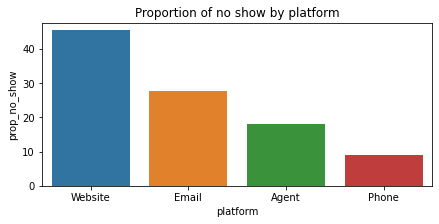

While the mean percentage across all platfoms is 36.92%, which is close to overall dataset 37.04%
However, we can see that Website forms the majority of no shows at 45.34%


In [67]:
# 4. Is there a difference in no-show between booking platforms?
platform = df.groupby("platform")["no_show"].agg(["sum", "count"]).reset_index()
platform["pct_no_show"] = round((platform["sum"]/platform["count"])*100,2)
platform["prop_no_show"] = round((platform["sum"]/platform["sum"].sum())*100,2)
platform = platform.sort_values("prop_no_show",ascending=False).reset_index(drop=True) 
print(platform)

# Plotting
plt.figure(figsize = (7,3))
sns.barplot(data=platform, x="platform", y="prop_no_show", order=platform.sort_values("prop_no_show", ascending=False).platform).set(title="Proportion of no show by platform")
plt.show()

# Findings
print(f"While the mean percentage across all platfoms is {platform.pct_no_show.mean()}%, which is close to overall dataset {imb.iloc[1,2]}%")
print(f"However, we can see that {platform.iloc[0,0]} forms the majority of no shows at {platform.iloc[0,-1]:.2f}%")

    branch    sum  count  pct_no_show  prop_no_show
0   Changi  33102  79330        41.73         74.85
1  Orchard  11122  40060        27.76         25.15


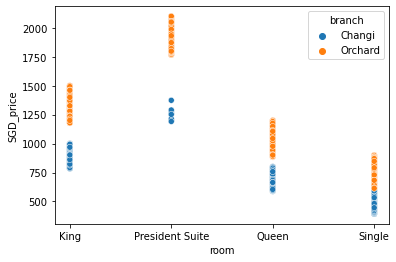

There seems to be more no shows at the Changi Branch as compared to the Orchard Branch
Changi branch is also cheaper compared to Orchard across all categories


In [20]:
# 5. Is there a difference in no-show between the different hotel branches
branches = df.groupby("branch")["no_show"].agg(["sum", "count"]).reset_index()
branches["pct_no_show"] = round((branches["sum"]/branches["count"])*100,2)
branches["prop_no_show"] = round((branches["sum"]/branches["sum"].sum())*100,2)
print(branches)

# Wanted to find out if the Changi branch is cheaper than the Orchard branch
sns.scatterplot(data=df, x="room", y="SGD_price", hue="branch")
plt.show()

# Findings
print("There seems to be more no shows at the Changi Branch as compared to the Orchard Branch")
print("Changi branch is also cheaper compared to Orchard across all categories")

  first_time    sum   count  pct_no_show  prop_no_show
0      False    552    3810        14.49          1.25
1       True  43672  115580        37.79         98.75


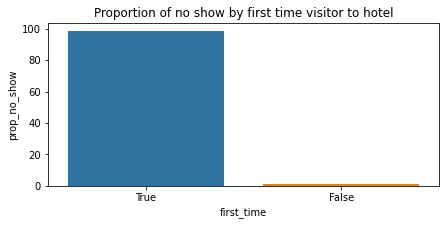

First time customers make up the overwhelming proportion of no show at 98.75%


In [68]:
# 6. Are first time customers more likely to no-show?
first = df.groupby("first_time")["no_show"].agg(["sum", "count"]).reset_index()
first["pct_no_show"] = round((first["sum"]/first["count"])*100,2)
first["prop_no_show"] = round((first["sum"]/first["sum"].sum())*100,2)
print(first)

# Plotting
plt.figure(figsize = (7,3))
sns.barplot(data=first, x="first_time", y="prop_no_show", order=first.sort_values("prop_no_show", ascending=False).first_time).set(title="Proportion of no show by first time visitor to hotel")
plt.show()

# Findings
print(f"First time customers make up the overwhelming proportion of no show at {first.iloc[1,-1]}%")

Object `show` not found.
The interquartile range is 605.75
2099.96 998.18 903.83 816.31 392.43
The bottom bound (-1.5*IQR) is -516.19 and the top bound (+1.5*IQR) is 1906.8
  price_types    sum  count  pct_no_show  prop_no_show
0      Lowest   8350  23630        35.34         23.88
1       Lower  10023  23624        42.43         28.66
2       Upper   9972  23628        42.20         28.51
3        High   6627  23626        28.05         18.95


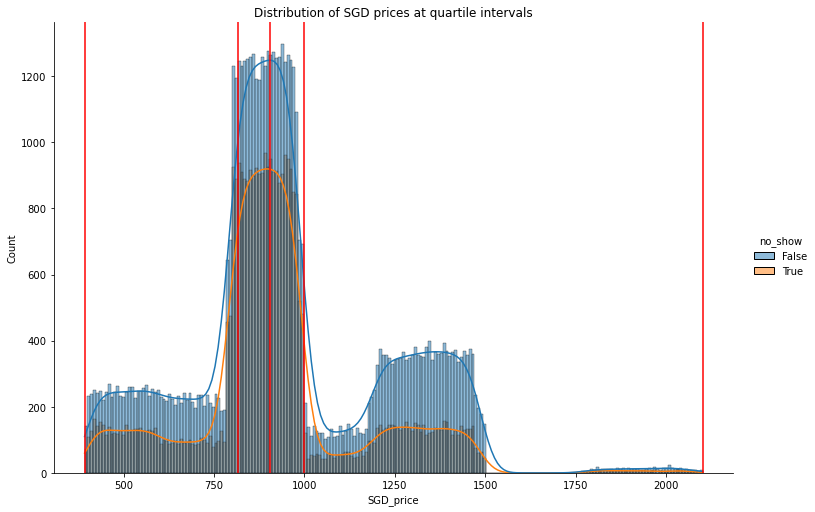

From the distribution plot we can see that the distribution of the no show is inline with distribution of prices


In [75]:
 7. Is low room price a reason for no-show?
# Since this is a continuous variable, need to discretize the information to understanding distribution
# 2 methods were used, 1) Percentile and 2) Equal sized bins

# What is the average, minimum and maximum prices?")
# print(df.SGD_price.describe())

# Calculating the relevant bin sizes by percentile
q4, q3, qm, q2, q1 = np.nanpercentile(df.SGD_price, [100, 75, 50, 25, 0])
price_iqr = round(q3-q1,2)
top_bound = round(q3+1.5*price_iqr,2)
btm_bound = round(q1-1.5*price_iqr,2)
print(f"The interquartile range is {price_iqr}")
print(q4, q3, qm, q2, q1)
print(f"The bottom bound (-1.5*IQR) is {btm_bound} and the top bound (+1.5*IQR) is {top_bound}")

# Bin the SGD prices according to [0-25, 25-50, 50-75, 75-100] values
labels = ["Lowest", "Lower", "Upper", "High"]
bins = [q1, q2, qm, q3, q4]
df["price_types"] = pd.cut(df.SGD_price, bins=bins,  labels=labels, ordered=True)

# Table of prices cut by equal sizes
price_per = df.groupby("price_types")["no_show"].agg(["sum", "count"]).reset_index()
price_per["pct_no_show"] = round((price_per["sum"]/price_per["count"])*100,2)
price_per["prop_no_show"] = round((price_per["sum"]/price_per["sum"].sum())*100,2)
print(price_per)

# Plotting distribution of SGD_Prices and cutting points at quartiles
sns.displot(data=df, x="SGD_price", hue="no_show", kde=True, height=7, aspect=12/8).set(title="Distribution of SGD prices at quartile intervals")
plt.axvline(q1, 0, 1200, color="red")
plt.axvline(q2, 0, 1200, color="red")
plt.axvline(qm, 0, 1200, color="red")
plt.axvline(q3, 0, 1200, color="red")
plt.axvline(q4, 0, 1200, color="red")
plt.show()

# Findings
print("""
From the distribution plot we can see that the distribution of the no show is inline with distribution of prices, 
proportion of no show is also more evenly distributed if divided by quartiles""")

  price_types    sum  count  pct_no_show  prop_no_show
0      Lowest   4883  14932        32.70         13.96
1       Lower  24050  57858        41.57         68.77
2      Middle   4685  16746        27.98         13.40
3       Upper   1124   4262        26.37          3.21
4        High    231    711        32.49          0.66


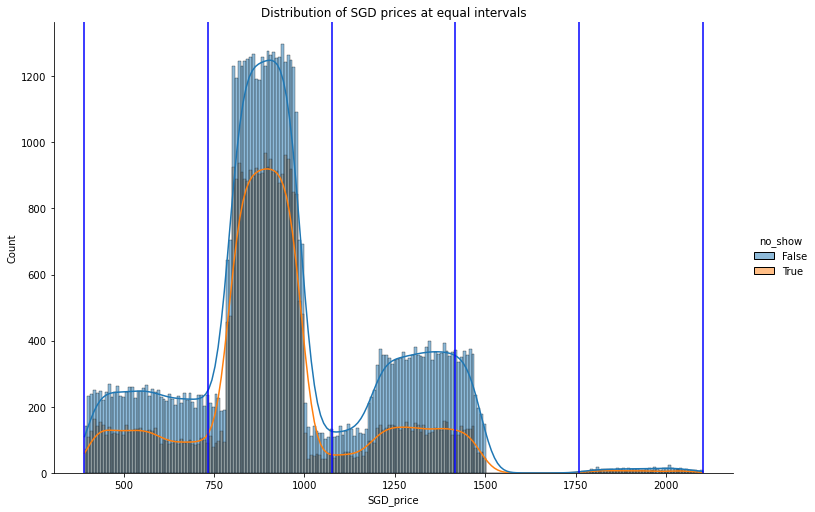

If divided by equal parts the data is less 'bunched'.


In [74]:
# 7. Is low room price a reason for no-show? cont'
# Bin the SGD prices according to [0-25, 25-50, 50-75, 75-100] values
labels = ["Lowest", "Lower", "Middle" ,"Upper", "High"]
df["price_types"] = pd.cut(df.SGD_price, bins=5,  labels=labels, ordered=True)

# Table of prices cut by equal sizes
price_eq = df.groupby("price_types")["no_show"].agg(["sum", "count"]).reset_index()
price_eq["pct_no_show"] = round((price_eq["sum"]/price_eq["count"])*100,2)
price_eq["prop_no_show"] = round((price_eq["sum"]/price_eq["sum"].sum())*100,2)
print(price_eq)

# Plotting distribution of SGD_Prices and cutting points at equal intervals
sns.displot(data=df, x="SGD_price", hue="no_show", kde=True, height=7, aspect=12/8).set(title="Distribution of SGD prices at equal intervals")
plt.axvline(390.72247, 0, 1200, color="blue")
plt.axvline(733.936, 0, 1200, color="blue")
plt.axvline(1075.442, 0, 1200, color="blue")
plt.axvline(1416.948, 0, 1200, color="blue")
plt.axvline(1758.454, 0, 1200, color="blue")
plt.axvline(2099.96, 0, 1200, color="blue")
plt.show()

# Findings
print("""
If divided by equal parts the data is less 'bunched',
also proportionally we can see that certain segments are more likely to no_show
""")

In [24]:
# 8. Is room type a factor for no-show?
room = df.copy()
room["room"] = room.room.astype(str)
room["room"] = room.room.replace("nan","Missing")
room = room.groupby("room")["no_show"].agg(["sum","count"])
room["pct_no_show"] = round((room["sum"]/room["count"])*100,2)
print(room)

# Findings
print(f"The mean percentage of no show across rooms is {round(room.pct_no_show.mean(),2)}%, which is close to overall dataset {imb.iloc[1,2]}%")
print(f"There is no obvious trend between room type and not showing up")

                   sum  count  pct_no_show
room                                      
King             27617  70496        39.18
Missing           7947  21612        36.77
President Suite    261    761        34.30
Queen             3394  10824        31.36
Single            5005  15697        31.89
The mean percentage of no show across rooms is 34.7%, which is close to overall dataset 37.04%
There is no obvious trend between room type and not showing up
